# Example: Nonlinear Map with Uniform Sampling
([From BET Documentation](http://ut-chg.github.io/BET/examples/example_rst_files/nonlinearMapUniformSampling.html#nonlinearmap))

We will walk through the following [example](nonlinearMapUniformSampling.py). This example generates uniform samples in a 2D input parameter space and evaluates a nonlinear map to either a 1D or 2D output data space. The purpose of this example is to study the effect of using different maps to solve the stochastic inverse problem. The nonlinear map is defined as either one or two quantities of interest (QoI) which are defined as spatial observations of the solution to the elliptic PDE

\begin{cases} -\nabla \cdot (A(\lambda)\cdot\nabla u) &= f(x,y;\lambda), \ (x,y)\in\Omega, \\ u|_{\partial \Omega} &= 0, \end{cases}

where

\begin{split}A(\lambda)=\left(\begin{array}{cc} 1/\lambda_1^2 & 0 \\ 0 & 1/\lambda_2^2 \end{array}\right),\end{split}

$$ f(x,y;\lambda) = \pi^2 \sin(\pi x\lambda_1)\sin(\pi y \lambda_2), $$

and

$$ \Omega=[0,1]\times[0,1]. $$

The user can change the number and placement of the QoI by editing this information in [myModel](myModel.py). A reference parameter is used to define a reference QoI datum and a uniform probability measure is defined on a small box centered at this datum. The measure on the data space is discretized either randomly or deterministically, and this discretized measure is then inverted by BET to determine a probability measure on the parameter space whose support contains the measurable sets of probable parameters. We often use emulation to estimate the measures of sets when random sampling is used. 1D and 2D marginals are calculated, smoothed, and plotted.

The actual process is quite simple requiring a total of 5 steps to solve the stochastic inverse problem with BET excluding any post-processing the user may want. In general the user will probably not write code with various options as was done here for pedagogical purposes. We break down the actual example included with BET step-by-step below, but first, to showcase the overall simplicitly, we show the “entire” code (omitting setting the environment, post-processing, and commenting) required for solving the stochastic inverse problem using some default options:

```python

sampler = bsam.sampler(my_model)

input_samples = samp.sample_set(2)
input_samples.set_domain(np.array([[3.0, 6.0],
                               [1.0, 5.0]]))
input_samples = sampler.regular_sample_set(input_samples, num_samples_per_dim=[50, 50])
input_samples.estimate_volume_mc()

my_discretization = sampler.compute_QoI_and_create_discretization(input_samples)

param_ref = np.array([5.5, 4.5])
Q_ref =  my_model(param_ref)
simpleFunP.regular_partition_uniform_distribution_rectangle_scaled(
    data_set=my_discretization, Q_ref=Q_ref, rect_scale=0.25,
    cells_per_dimension = 3)

calculateP.prob(my_discretization)

```

## Step (0): Setting up the environment
Import the necessary modules:

In [1]:
import numpy as np
import bet.calculateP.simpleFunP as simpleFunP
import bet.calculateP.calculateP as calculateP
import bet.postProcess.plotP as plotP
import bet.postProcess.plotDomains as plotD
import bet.sample as samp
import bet.sampling.basicSampling as bsam

## Step (1): Define interface to the model
Import the Python script interface to the Python [model](myModel.py) that takes as input a numpy array of model input parameter samples, generated from the sampler (see below), evaluates the model to generate QoI samples, and returns the QoI samples:

In [2]:
from myModel import my_model

Define the sampler that will be used to create the discretization object, which is the fundamental object used by BET to compute solutions to the stochastic inverse problem. The sampler and my_model is the interface of BET to the model, and it allows BET to create input/output samples of the model:

In [3]:
sampler = bsam.sampler(my_model)

### Suggested changes for user exploration (1):
Explore changes to the quantity of interest (QoI) by modifying the [model file](myModel.py). These edits to the file myModel.py can be made here in this Jupyter Notebook. 

First, load the file myModel.py by typing the magic command `%load myModel.py` at the top of the cell below and then running the cell. This will load an exact copy of the file in the cell.

In [ ]:
# %load myModel.py
# Copyright (C) 2016 The BET Development Team

# -*- coding: utf-8 -*-
import numpy as np
import math as m

'''
Suggested changes for user:

Try setting QoI_num = 2.

Play around with the x1, y1, and/or, x2, y2 values to try and
"optimize" the QoI to give the highest probability region
on the reference parameter above.

Hint: Try using QoI_num = 1 and systematically varying the
x1 and y1 values to find QoI with contour structures (as inferred
through the 2D marginal plots) that are nearly orthogonal.

Some interesting pairs of QoI to compare are:
(x1,y1)=(0.5,0.5) and (x2,y2)=(0.25,0.25)
(x1,y1)=(0.5,0.5) and (x2,y2)=(0.15,0.15)
(x1,y1)=(0.5,0.5) and (x2,y2)=(0.25,0.15)
'''
# Choose the number of QoI
QoI_num = 1

# Specify the spatial points to take measurements of solution defining the QoI
if QoI_num == 1:
    x1 = 0.5
    y1 = 0.5
    x = np.array([x1])
    y = np.array([y1])
else:
    x1 = 0.5
    y1 = 0.15
    x2 = 0.15
    y2 = 0.25
    x = np.array([x1, x2])
    y = np.array([y1, y2])

class QoI_component(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def eval(self, parameter_samples):
        if parameter_samples.shape == (2,):
            lam1 = parameter_samples[0]
            lam2 = parameter_samples[1]
        else:
            lam1 = parameter_samples[:,0]
            lam2 = parameter_samples[:,1]
        z = np.sin(m.pi * self.x * lam1) * np.sin(m.pi * self.y * lam2)
        return z

# Specify the QoI maps
if QoI_num == 1:
    def QoI_map(parameter_samples):
        Q1 = QoI_component(x[0], y[0])
        return np.array([Q1.eval(parameter_samples)]).transpose()
else:
    def QoI_map(parameter_samples):
        Q1 = QoI_component(x[0], y[0])
        Q2 = QoI_component(x[1], y[1])
        return np.array([Q1.eval(parameter_samples), Q2.eval(parameter_samples)]).transpose()

# Define a model that is the QoI map
def my_model(parameter_samples):
    QoI_samples = QoI_map(parameter_samples)
    return QoI_samples

In myModel.py file loaded in the cell above find the section of code which handles the QoI (the quantities of interest):
```python
# Choose the number of QoI
QoI_num = 1

# Specify the spatial points to take measurements of solution defining the QoI
if QoI_num == 1:
    x1 = 0.5
    y1 = 0.5
    x = np.array([x1])
    y = np.array([y1])
else:
    x1 = 0.5
    y1 = 0.15
    x2 = 0.15
    y2 = 0.25
    x = np.array([x1, x2])
    y = np.array([y1, y2])
```

Try different choices of QoI by changing the `x1`, `y1`, and/or, `x2`, `y2` (if you have set `QoI_num = 2`) in order to “optimize” the QoI so that the solution to the stochastic inverse problem is a small region of high probability centered around the reference parameter (see below for more information on choosing the reference parameter in the main script).

It is a good idea to start with `QoI_num = 1` and systematically vary the `x1` and `y1` values to find QoI with contour structures (as inferred through the 2D marginal plots) that are nearly orthogonal.

Some interesting pairs of QoI to compare are:

* `(x1,y1)=(0.5,0.5)` and `(x2,y2)=(0.25,0.25)`
* `(x1,y1)=(0.5,0.5)` and `(x2,y2)=(0.15,0.15)`
* `(x1,y1)=(0.5,0.5)` and `(x2,y2)=(0.25,0.15)`

When you have made the appropriate edits to myModel.py, save the file by deleting the first line in the cell (`# %load myModel.py`) and then typing and running the magic command `%%writefile myModel.py`. This will write the edits you have made to the myModel.py file.

*Note: the `%%writefile myModel.py` magic command must be at the top of the cell to write the file properly. To reload the file, just delete the writefile magic command and type the magic command %load myModel.py to the top of the cell.*

## Step (2): Describe and sample the input space
Initialize the (2-dimensional) input parameter sample set object and set the parameter domain (chosen here so that the QoI maps have interesting features):

In [26]:
input_samples = samp.sample_set(2)
input_samples.set_domain(np.array([[3.0, 6.0],
                           [1.0, 5.0]]))

### Suggested changes for user exploration (2):
Try with and without random sampling.

If using **random** sampling:

* Try `num_samples = 1E3` and `num_samples = 1E4` 
* See what happens when `num_samples = 1E2`
* Try using `'lhs'` instead of `'random'` in the `random_sample_set`

If using **regular** sampling, try different numbers of samples per dimension:

In [27]:
randomSampling = False
if randomSampling is True:
    input_samples = sampler.random_sample_set('random', input_samples, num_samples=1E4)
else:
    input_samples = sampler.regular_sample_set(input_samples, num_samples_per_dim=[50, 50])

### Suggested changes for user exploration (3):
A standard Monte Carlo (MC) assumption is that every Voronoi cell has the same volume. If a regular grid of samples was used, then the standard MC assumption is true.

See what happens if the MC assumption is not assumed to be true, and if different numbers of points are used to estimate the volumes of the Voronoi cells:


In [28]:
MC_assumption = True
if MC_assumption is False:
    input_samples.estimate_volume(n_mc_points=1E5)
else:
    input_samples.estimate_volume_mc()

## Step (3): Generate QoI samples
Create the discretization object holding all the input (parameter) samples and output (QoI) samples using the sampler:

In [29]:
my_discretization = sampler.compute_QoI_and_create_discretization(input_samples,
                                           savefile = 'NonlinearExample.txt.gz')

At this point, all of the model information has been extracted for BET (with the possibly exception of evaluating the model to generate a reference QoI datum or a distribution of the QoI), so the model is no longer required for evaluation. The user could do Steps (0)-(3) in a separate script, and then simply load the discretization object as part of a separate BET script that does the remaining steps. When the model is expensive to evaluate, this is an attractive option since we can now solve the stochastic inverse problem (with many different distributions defined on the data space) without ever having to re-solve the model (so long as we are happy with the resolution provided by the current discretization of the parameter and data spaces).

## Step (4): Describe the data distribution
This problem is nominally a “parameter identification under uncertainty” problem. Thus, we take a reference QoI datum (from one more model solve), and define a distribution “around” this datum.

### Suggested changes for user exploration (4):
Try different reference parameters that produce different reference QoI data.:

In [30]:
param_ref = np.array([5.5, 4.5])
Q_ref =  my_model(param_ref)

Use the reference samples and discretization to generate plots (this is completely optional):

In [34]:
plotD.scatter_2D(input_samples, ref_sample = param_ref,
                                 filename = 'nonlinearMapParameterSamples.svg')
if Q_ref.size == 2:
        plotD.show_data_domain_2D(my_discretization, Q_ref = Q_ref, file_extension="svg")

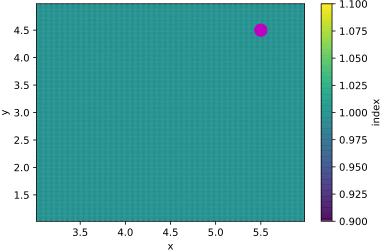

In [36]:
from IPython.display import SVG
SVG("nonlinearMapParameterSamples.svg")

### Suggested changes for user exploration (5):
Try different ways of discretizing the probability measure on the data space defined as a uniform probability measure on a rectangle centered at Q_ref whose size is determined by scaling the circumscribing box of the data space:

In [37]:
randomDataDiscretization = False
if randomDataDiscretization is False:
    simpleFunP.regular_partition_uniform_distribution_rectangle_scaled(
        data_set=my_discretization, Q_ref=Q_ref, rect_scale=0.25,
        cells_per_dimension = 3)
else:
    simpleFunP.uniform_partition_uniform_distribution_rectangle_scaled(
        data_set=my_discretization, Q_ref=Q_ref, rect_scale=0.25,
        M=50, num_d_emulate=1E5)

## Step (5): Solve the stochastic inverse problem
Calculate probablities on the parameter space (which are stored within the discretization object):



In [38]:
calculateP.prob(my_discretization)

## Step (6) [Optional]: Post-processing
There are ways to determine “optimal” smoothing parameters (e.g., see CV, GCV, and other similar methods), but we have not incorporated these into the code as lower-dimensional marginal plots generally have limited value in understanding the structure of a high dimensional non-parametric probability measure.

The user may want to change `nbins` or `sigma` in the `plotP.*` inputs (which influences the kernel density estimation with smaller values of `sigma` implying a density estimate that looks more like a histogram and larger values smoothing out the values more).

In general, the user will have to tune these for any given problem especially when looking at marginals of higher-dimensional problems with parameter ranges that have disparate scales (assuming the parameters were not first normalized as part of a “un-dimensionalization” of the space, which is highly encouraged):

In [41]:
(bins, marginals2D) = plotP.calculate_2D_marginal_probs(input_samples,
                                                                                                                nbins = [20, 20])

marginals2D = plotP.smooth_marginals_2D(marginals2D, bins, sigma=0.5)

plotP.plot_2D_marginal_probs(marginals2D, bins, input_samples, filename = "nonlinearMap",
                                                         lam_ref = param_ref, file_extension = ".svg", plot_surface=False)

(bins, marginals1D) = plotP.calculate_1D_marginal_probs(input_samples,
                                                                                                                nbins = [20, 20])

marginals1D = plotP.smooth_marginals_1D(marginals1D, bins, sigma=0.5)

plotP.plot_1D_marginal_probs(marginals1D, bins, input_samples, filename = "nonlinearMap",
                                                         lam_ref = param_ref, file_extension = ".svg")

In [43]:
# hack to refresh html after changes within notebook
import random
__counter__ = random.randint(0,2e9)

# displays 1D marginal probabilities
from IPython.display import HTML, display
display(HTML("<table><tr><td colspan=2><center>1D Marginals</center></td></tr>"+
             "<tr><td><img src='nonlinearMap_1D_0.svg?%d'></td>"% __counter__+
             "<td><img src='nonlinearMap_1D_1.svg?%d'></td></tr>"% __counter__+
             "<tr><td colspan=2><center>2D Marginals<img src='nonlinearMap_2D_0_1.svg?%d'></td></tr></center>"% __counter__+
             "</table>" ))